In [11]:
from pathlib import Path

import plotnine as pn
import polars as pl
import srsly
from src.utilities import load_tokenizer_with_vocab_size

In [2]:
path = Path("/home/pl487/rdd/tokenizer_train/2024-08-30T12-00-43/")

In [3]:
impl_merges = pl.DataFrame(srsly.read_jsonl(path / "implemented_merges.jsonl"))

In [4]:
impl_merges

pair,part_a,part_b,count,new_token_id,new_token
list[i64],str,str,i64,i64,str
"[175, 84]","""Ġ""","""t""",956771951,210,"""Ġt"""
"[175, 65]","""Ġ""","""a""",767475220,211,"""Ġa"""
"[72, 69]","""h""","""e""",718222604,212,"""he"""
"[73, 78]","""i""","""n""",675331749,213,"""in"""
"[82, 69]","""r""","""e""",518221150,214,"""re"""
…,…,…,…,…,…
"[630, 4634]","""Ġra""","""za""",330,319995,"""Ġraza"""
"[660, 12369]","""ĠY""","""asa""",330,319996,"""ĠYasa"""
"[660, 95888]","""ĠY""","""uccas""",330,319997,"""ĠYuccas"""


In [5]:
conf = srsly.read_json(path / "tokenizer.json")

In [10]:
pl.DataFrame([{"part_a": m[0], "part_b": m[1]} for m in conf["model"]["merges"]])

part_a,part_b
str,str
"""Ġ""","""t"""
"""Ġ""","""a"""
"""h""","""e"""
"""i""","""n"""
"""r""","""e"""
…,…
"""Ġra""","""za"""
"""ĠY""","""asa"""
"""ĠY""","""uccas"""


In [14]:
tok = load_tokenizer_with_vocab_size(path, 1000)

/home/pl487/rdd/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884


In [20]:
max(tok.vocab.values())

999

In [31]:
dir(tok.backend_tokenizer.model)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'byte_fallback',
 'continuing_subword_prefix',
 'dropout',
 'end_of_word_suffix',
 'from_file',
 'fuse_unk',
 'get_trainer',
 'id_to_token',
 'ignore_merges',
 'read_file',
 'save',
 'token_to_id',
 'tokenize',
 'unk_token']

In [29]:
vocab = pl.DataFrame({"tokens": [i for i in conf["model"]["vocab"]]})

In [32]:
vocab.join(impl_merges, left_on="tokens", right_on="new_token", how="anti")

tokens
str
"""|endoftext|"""
"""!"""
""""""""
"""#"""
"""$"""
…
"""Ŀ"""
"""ŀ"""
"""Ł"""


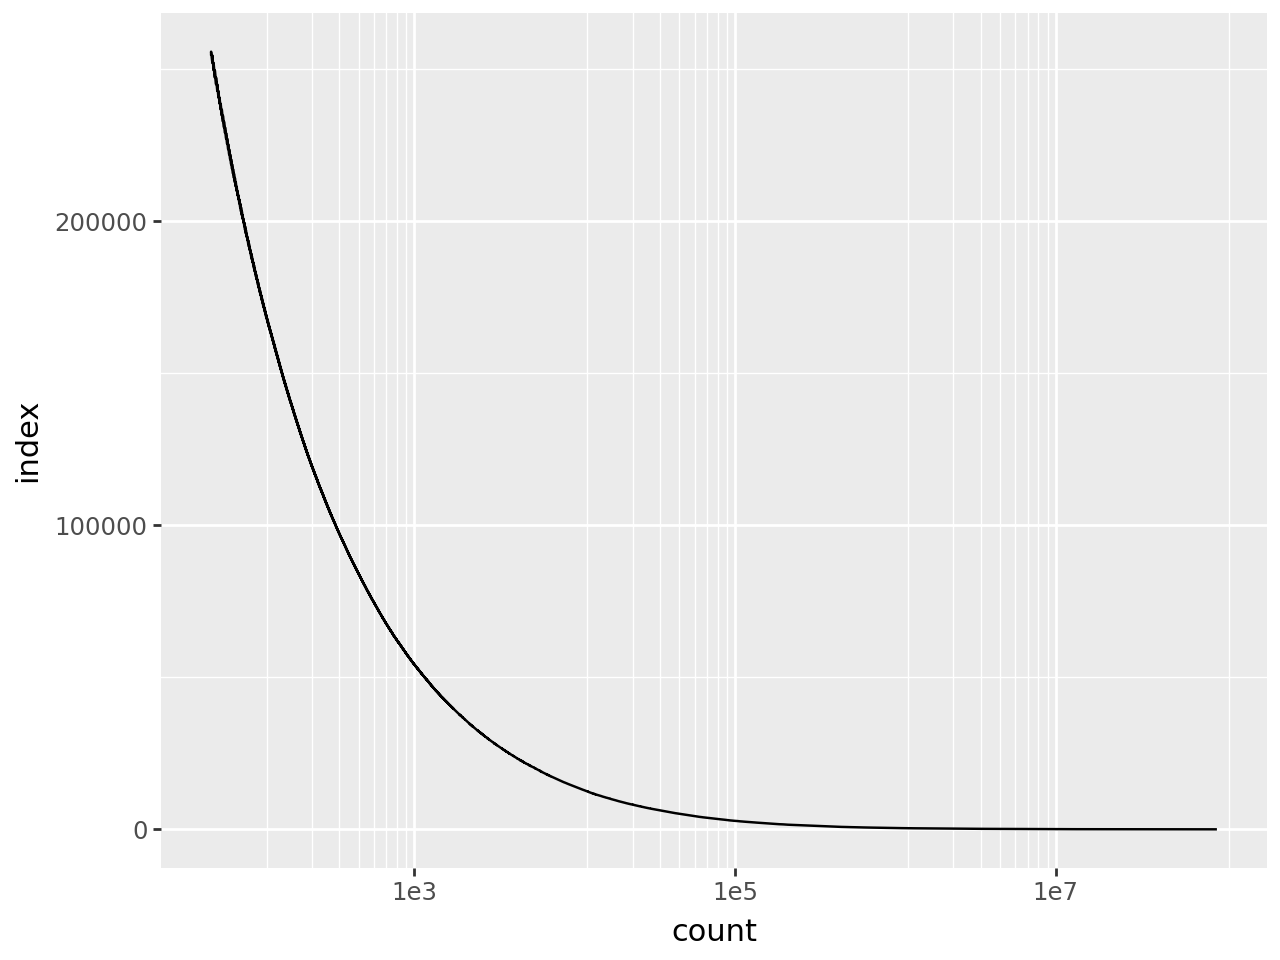

In [39]:
(
    pn.ggplot(impl_merges.with_row_index(), pn.aes(y="index", x="count")) +
    pn.geom_line() +
    pn.scale_x_log10()
)